In [28]:
import pandas as pd
import numpy as np

import flexcode
from flexcode.regression_models import CustomModel

from xgboost import XGBRegressor

import cdetools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold

from cdetools.cde_loss import cde_loss

from cdetools.hpd_coverage import hpd_coverage
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band


## Objectives
- Develop Metrics for Testing

- PanSTARRS vs SDSS
- PanSTARRS vs SDSS U + PanSTARRS

- Find whether 2MASS Filters improves model predictions (by how much)
- Is it better to use the 2MASS Filter Magnitudes or to encode 1, 0 for detection, no detection.

- Hyperparameter Tuning

### Data Preprocesing

In [29]:
#get data (this dataset was created by crosmatching the teddy dataset with SDSS, PanSTARRS and 2MASS)
df = pd.read_csv("TeddyCustom.csv")
#view
df.head()

SDSSID     SDSSRa   SDSSDec               PS1ID  PS1AngSep  \
0  1237645879577739681  49.873779  1.271194  109520498737885992   0.002551   
1  1237645942904520927  54.936769  0.216784  108260549367510630   0.001892   
2  1237645942904914122  55.717067  0.217682  108260557170261667   0.001987   
3  1237645942905110768  56.243814  0.216326  108260562437900045   0.001342   
4  1237645942905504072  57.075470  0.038348  108040570754586524   0.001540   

       PS1Ra    PS1Dec       TMassID  TMassAngSep    TMassRa  ...  \
0  49.873782  1.271280           NaN          NaN        NaN  ...   
1  54.936760  0.216837  8.538872e+08     0.004722  54.936696  ...   
2  55.717017  0.217711  7.839765e+08     0.003779  55.717017  ...   
3  56.243769  0.216336           NaN          NaN        NaN  ...   
4  57.075460  0.038408  1.331737e+09     0.009250  57.075617  ...   

   zKronMagErr  yKronMagErr        j_m        h_m     k_m  j_err  h_err  \
0     0.022784     0.040340        NaN        NaN     NaN    NaN    NaN   
1     0.007639     0.009580  17.091999  16.963000  16.263  0.160  0.159   
2     0.010557     0.018087  17.510000  17.331000  17.075  0.157  0.173   
3     0.012939     0.021645        NaN        NaN     NaN    NaN    NaN   
4     0.014055     0.022498  17.867001  17.394999  16.839  0.169  0.168   

   k_err         z      ZErr  
0    NaN  0.293778  0.000078  
1  0.114  0.201237  0.000050  
2  0.185  0.299481  0.000050  
3    NaN  0.309728  0.000043  
4  0.123  0.349115  0.000070  

[5 rows x 39 columns]

In [30]:
df.columns

Index(['SDSSID', 'SDSSRa', 'SDSSDec', 'PS1ID', 'PS1AngSep', 'PS1Ra', 'PS1Dec',
       'TMassID', 'TMassAngSep', 'TMassRa', 'TMassDec', 'SDSS_uMag',
       'SDSS_gMag', 'SDSS_rMag', 'SDSS_iMag', 'SDSS_zMag', 'SDSS_uMagErr',
       'SDSS_gMagErr', 'SDSS_rMagErr', 'SDSS_iMagErr', 'SDSS_zMagErr',
       'gKronMag', 'rKronMag', 'iKronMag', 'zKronMag', 'yKronMag',
       'gKronMagErr', 'rKronMagErr', 'iKronMagErr', 'zKronMagErr',
       'yKronMagErr', 'j_m', 'h_m', 'k_m', 'j_err', 'h_err', 'k_err', 'z',
       'ZErr'],
      dtype='object')

In [31]:
def preprocess_data(df):
    #not needed for model creation
    df = df.drop(["SDSSRa","SDSSDec","PS1ID","PS1Ra","PS1Dec",
                  "PS1AngSep","TMassID","TMassRa","TMassDec",
                  "TMassAngSep","ZErr"], axis=1)
    #renaming for ease
    renamed = {"gKronMag":"gMag","rKronMag":"rMag","iKronMag":"iMag",
               "zKronMag":"zMag","yKronMag":"yMag","j_m":"jMag",
               "h_m":"hMag","k_m":"kMag"}
    df = df.rename(columns=renamed)
    return df

In [32]:
data = df.pipe(preprocess_data)

### Feature Creation

In [33]:
data.head()

SDSSID  SDSS_uMag  SDSS_gMag  SDSS_rMag  SDSS_iMag  SDSS_zMag  \
0  1237645879577739681   23.00731   21.34087   19.74872   19.14171   18.80783   
1  1237645942904520927   21.30060   19.02486   17.60062   17.04626   16.69721   
2  1237645942904914122   22.28164   20.27043   18.58679   17.99218   17.72025   
3  1237645942905110768   22.95518   20.72871   19.22448   18.66721   18.32628   
4  1237645942905504072   22.78355   21.08486   18.89280   18.15070   17.72170   

   SDSS_uMagErr  SDSS_gMagErr  SDSS_rMagErr  SDSS_iMagErr  ...  iKronMagErr  \
0      0.663544      0.065260      0.026834      0.026258  ...     0.013203   
1      0.180828      0.014182      0.007199      0.006362  ...     0.004274   
2      0.313823      0.028656      0.011433      0.009821  ...     0.007739   
3      0.405977      0.031762      0.014333      0.012447  ...     0.008142   
4      0.551446      0.063007      0.015269      0.011694  ...     0.008425   

   zKronMagErr  yKronMagErr       jMag       hMag    kMag  j_err  h_err  \
0     0.022784     0.040340        NaN        NaN     NaN    NaN    NaN   
1     0.007639     0.009580  17.091999  16.963000  16.263  0.160  0.159   
2     0.010557     0.018087  17.510000  17.331000  17.075  0.157  0.173   
3     0.012939     0.021645        NaN        NaN     NaN    NaN    NaN   
4     0.014055     0.022498  17.867001  17.394999  16.839  0.169  0.168   

   k_err         z  
0    NaN  0.293778  
1  0.114  0.201237  
2  0.185  0.299481  
3    NaN  0.309728  
4  0.123  0.349115  

[5 rows x 28 columns]

<Axes: xlabel='rMag', ylabel='Count'>

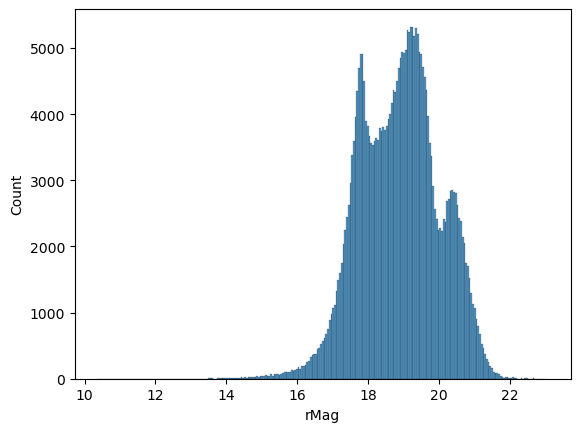

In [34]:
sns.histplot(data.rMag)

In [35]:
def SDSS_features(df):
    #creating colour features
    df["ug_SDSS"] = df.SDSS_uMag - df.SDSS_gMag
    df["gr_SDSS"] = df.SDSS_gMag - df.SDSS_rMag
    df["ri_SDSS"] = df.SDSS_rMag - df.SDSS_iMag
    df["iz_SDSS"] = df.SDSS_iMag - df.SDSS_zMag
    #normalising rMag
    df["rMagNormSDSS"] = preprocessing.scale(df.SDSS_rMag.values)
    #normalising colour data
    df["ugNormSDSS"] = preprocessing.scale(df.ug_SDSS.values)
    df["grNormSDSS"] = preprocessing.scale(df.gr_SDSS.values)
    df["riNormSDSS"] = preprocessing.scale(df.ri_SDSS.values)
    df["izNormSDSS"] = preprocessing.scale(df.iz_SDSS.values)
    return df

In [36]:
def PS_features(df):
    #creating colour features
    df["ug"] = df.SDSS_uMag - df.gMag
    df["gr_PS"] = df.gMag - df.rMag
    df["ri_PS"] = df.rMag - df.iMag
    df["iz_PS"] = df.iMag - df.zMag
    df["zy_PS"] = df.zMag - df.yMag
    #normalising rMag
    df["rMagNormPS"] = preprocessing.scale(df.rMag.values)
    #normalising colour data
    df["ugNorm"] = preprocessing.scale(df.ug.values)
    df["grNormPS"] = preprocessing.scale(df.gr_PS.values)
    df["riNormPS"] = preprocessing.scale(df.ri_PS.values)
    df["izNormPS"] = preprocessing.scale(df.iz_PS.values)
    df["zyNormPS"] = preprocessing.scale(df.zy_PS.values)
    return df

In [37]:
def twoMassMap(x):
    """
    Function to map to 2mass detections to indicate if a counterpart
    was detected during crossmatching.
    """
    if pd.isna(x):
        return 0
    else:
        return 1

def twoMass_features(df):
    df["yj"] = df.yMag - df.jMag
    df["jh"] = df.jMag - df.hMag
    df["hk"] = df.hMag - df.kMag
    #normalising
    df["yjNorm"] = preprocessing.scale(df.yj.values)
    df["jhNorm"] = preprocessing.scale(df.jh.values)
    df["hkNorm"] = preprocessing.scale(df.hk.values)
    # #dummy encoding
    df["jDetected"] = df.jMag.map(twoMassMap)
    df["hDetected"] = df.hMag.map(twoMassMap)
    df["kDetected"] = df.kMag.map(twoMassMap)
    return df

In [38]:
def colour_errors(df):
    df["ugErr"] = np.sqrt((df.SDSS_uMagErr)**2 + (df.gKronMagErr)**2)
    df["grErr"] = np.sqrt((df.gKronMagErr)**2 + (df.rKronMagErr)**2)
    df["riErr"] = np.sqrt((df.rKronMagErr)**2 + (df.iKronMagErr)**2)
    df["izErr"] = np.sqrt((df.iKronMagErr)**2 + (df.zKronMagErr)**2)
    df["zyErr"] = np.sqrt((df.zKronMagErr)**2 + (df.yKronMagErr)**2)
    df["yjErr"] = np.sqrt((df.yKronMagErr)**2 + (df.j_err)**2)
    df["jhErr"] = np.sqrt((df.j_err)**2 + (df.h_err)**2)
    df["hkErr"] = np.sqrt((df.h_err)**2 + (df.k_err)**2)
    
    df["rMagErrNorm"] = preprocessing.scale(df.rKronMagErr.values)
    df["ugErrNorm"] = preprocessing.scale(df.ugErr.values)
    df["grErrNorm"] = preprocessing.scale(df.grErr.values)
    df["riErrNorm"] = preprocessing.scale(df.riErr.values)
    df["izErrNorm"] = preprocessing.scale(df.izErr.values)
    df["zyErrNorm"] = preprocessing.scale(df.zyErr.values)
    df["yjErrNorm"] = preprocessing.scale(df.yjErr.values)
    df["jhErrNorm"] = preprocessing.scale(df.jhErr.values)
    df["hkErrNorm"] = preprocessing.scale(df.hkErr.values)


    return df

In [39]:
data = (data.pipe(SDSS_features)
        .pipe(PS_features)
        .pipe(twoMass_features)
        .pipe(colour_errors))

In [40]:
data.to_csv("all_teddy_custom_data.csv", index=False)

In [41]:
data.columns

Index(['SDSSID', 'SDSS_uMag', 'SDSS_gMag', 'SDSS_rMag', 'SDSS_iMag',
       'SDSS_zMag', 'SDSS_uMagErr', 'SDSS_gMagErr', 'SDSS_rMagErr',
       'SDSS_iMagErr', 'SDSS_zMagErr', 'gMag', 'rMag', 'iMag', 'zMag', 'yMag',
       'gKronMagErr', 'rKronMagErr', 'iKronMagErr', 'zKronMagErr',
       'yKronMagErr', 'jMag', 'hMag', 'kMag', 'j_err', 'h_err', 'k_err', 'z',
       'ug_SDSS', 'gr_SDSS', 'ri_SDSS', 'iz_SDSS', 'rMagNormSDSS',
       'ugNormSDSS', 'grNormSDSS', 'riNormSDSS', 'izNormSDSS', 'ug', 'gr_PS',
       'ri_PS', 'iz_PS', 'zy_PS', 'rMagNormPS', 'ugNorm', 'grNormPS',
       'riNormPS', 'izNormPS', 'zyNormPS', 'yj', 'jh', 'hk', 'yjNorm',
       'jhNorm', 'hkNorm', 'jDetected', 'hDetected', 'kDetected', 'ugErr',
       'grErr', 'riErr', 'izErr', 'zyErr', 'yjErr', 'jhErr', 'hkErr',
       'rMagErrNorm', 'ugErrNorm', 'grErrNorm', 'riErrNorm', 'izErrNorm',
       'zyErrNorm', 'yjErrNorm', 'jhErrNorm', 'hkErrNorm'],
      dtype='object')

In [42]:
# data = data[['rMagNormSDSS','ugNormSDSS', 'grNormSDSS', 'riNormSDSS', 'izNormSDSS',
#              'rMagNormPS', 'ugNorm', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS',
#              'yjNorm', 'jhNorm', 'hkNorm','SDSS_uMagErr', 'SDSS_gMagErr', 'SDSS_rMagErr',
#              'SDSS_iMagErr', 'SDSS_zMagErr','gKronMagErr', 'rKronMagErr', 'iKronMagErr', 'zKronMagErr',
#              'yKronMagErr','j_err', 'h_err', 'k_err','z']].copy()
data = data[['rMagNormPS', 'ugNorm', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS',
             'yjNorm', 'jhNorm', 'hkNorm',
             'rMagErrNorm', 'ugErrNorm', 'grErrNorm', 'riErrNorm', 'izErrNorm',
             'zyErrNorm', 'yjErrNorm', 'jhErrNorm', 'hkErrNorm', 'z']].copy()

In [44]:
data

rMagNormPS    ugNorm  grNormPS  riNormPS  izNormPS  zyNormPS  \
0         0.861103 -0.525968  0.800274  0.051306  0.188682 -0.128585   
1        -1.027598  0.766316 -0.308370 -0.639780  0.552702  0.121677   
2        -0.117662  0.242561  0.479117  0.101095 -1.073553  0.074206   
3         0.414285  0.866369 -0.410426 -0.016097 -0.061049 -0.219193   
4         0.129931  0.417029  0.771342 -0.160947  3.109370  0.435198   
...            ...       ...       ...       ...       ...       ...   
296675    0.531571  0.131023  0.435186  0.220302  0.691551 -0.060993   
296676    0.061897 -0.646283 -0.463727 -0.022630 -0.244771  0.479788   
296677   -0.266130 -0.349592  0.330729 -0.189622  0.026985  0.437365   
296678   -0.931040 -0.642325  0.849825 -0.501962 -0.536824 -0.644198   
296679    1.381002 -2.679056  1.127592  1.890657  2.166266 -0.271685   

          yjNorm    jhNorm    hkNorm  rMagErrNorm  ugErrNorm  grErrNorm  \
0            NaN       NaN       NaN     0.555185   0.385955   0.538520   
1      -0.735974 -0.759589  2.104363    -0.753973  -0.818147  -0.726010   
2       1.198430 -0.545484  0.285779    -0.493752  -0.486317  -0.376456   
3            NaN       NaN       NaN    -0.411200  -0.257933  -0.297500   
4      -0.469799  0.709147  1.514548    -0.340004   0.107061   0.267363   
...          ...       ...       ...          ...        ...        ...   
296675       NaN       NaN       NaN    -0.164268   0.259247  -0.041879   
296676  1.207215 -0.352794 -0.549788    -0.368917  -0.712142  -0.403725   
296677  0.055529 -0.348510  2.513955    -0.422959  -0.101388  -0.375788   
296678 -1.169939  0.589243  0.986177    -0.705891  -0.653127  -0.486427   
296679       NaN       NaN       NaN     1.129587  -0.117455   2.057416   

        riErrNorm  izErrNorm  zyErrNorm  yjErrNorm  jhErrNorm  hkErrNorm  \
0        0.530870   0.723346   0.746253        NaN        NaN        NaN   
1       -0.796356  -0.782333  -0.884297   0.522271   0.402270  -0.147229   
2       -0.460925  -0.410925  -0.468498   0.470987   0.537812   0.864269   
3       -0.385684  -0.222686  -0.263943        NaN        NaN        NaN   
4       -0.323130  -0.128548  -0.201266   0.755054   0.616545   0.073329   
...           ...        ...        ...        ...        ...        ...   
296675  -0.178646  -0.184807  -0.089894        NaN        NaN        NaN   
296676  -0.402984  -0.349329  -0.408045   0.110606   0.440921   1.103472   
296677  -0.370579  -0.255419  -0.521624   0.692182   1.161432   0.618303   
296678  -0.659956  -0.587277  -0.439755   1.245829   0.745900  -0.019158   
296679   1.112127   0.981841   0.586451        NaN        NaN        NaN   

               z  
0       0.293778  
1       0.201237  
2       0.299481  
3       0.309728  
4       0.349115  
...          ...  
296675  0.343875  
296676  0.282889  
296677  0.291777  
296678  0.296219  
296679  0.522893  

[296680 rows x 19 columns]

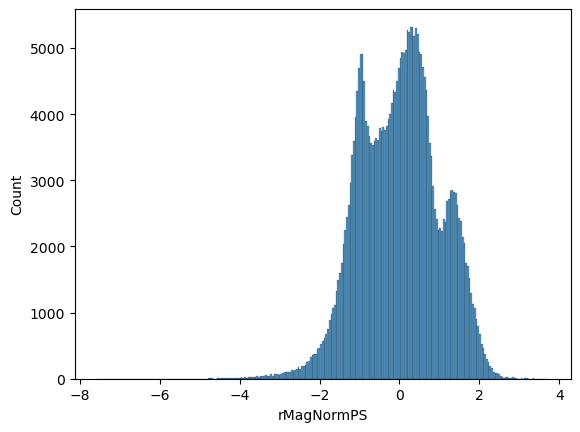

In [19]:
sns.histplot(data.rMagNormPS)
plt.show()

### Visualisation

In [20]:
# sns.histplot(data=data, x=data.query("z<1").z, color="mediumseagreen")

# sns.histplot(data=data, x=data.query("z<1 & jDetected==0").z,color="royalblue")

# sns.histplot(data=data, x=data.query("z<1 & jDetected==1").z, color="indianred")

# plt.show()

- Red: Detections without Missing 2MASS Information.
- Blue: Detections with Missing 2MASS Information
- Green: All Detections

Alot of the higher spectroscopic detections have missing 2MASS data.

### Evaluation Metrics

Proposed Evaluation Methods:
- How many "true zs" lies in a probable zone?
- On Average how many std. dev is the true value away from the most probable region? (visualise this)

In [21]:
def plot_cde(cde_list, zgrid, y_test, shape):
    nrows = shape[0]
    ncols = shape[1]
    fig = plt.figure(figsize=(40, 20))
    for i, cde in enumerate(cde_list[:(nrows*ncols),:]):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        plt.plot(zgrid, cde, label=r'$\hat{p}(z| x_{\rm obs})$')
        plt.axvline(y_test.values[i], color='red', label=r'$z_{\rm obs}$')
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.xlabel(r'Redshift $z$', size=20)
        plt.ylabel('CDE', size=20)
        plt.xlim(0,1)
        plt.legend(loc='upper right', prop={'size': 20})
    plt.show()
    return

In [22]:
def plot_cde_range(cdes, y_test, zgrid, val_range, shape, subset=None, roi=True):
    lwr = val_range[0]
    upr = val_range[1]
    nrows = shape[0]
    ncols = shape[1]
    
    zVals = y_test.reset_index(drop=True)
    if type(zVals) == pd.core.frame.DataFrame:
        test_inds = zVals.query("z>@lwr & z<@upr").index.values.tolist()
    else:
        zVals = zVals.to_frame()
        test_inds = zVals.query("z>@lwr & z<@upr").index.values.tolist()
    n_tests = len(test_inds) # list of indices of zVals within target range 

    if subset != None:
        #if start point > list no points to plot
        if subset[0] > n_tests:
            raise IndexError("No Values in Range")
            #else if end point 
        elif subset[1] > n_tests:
            subset[1] = n_tests
        test_inds = test_inds[subset[0]:subset[1]]
        n_tests = len(test_inds)
    
    fig = plt.figure(figsize=(40, 20))

    for plotNum in range(nrows*ncols):
        if plotNum == n_tests:
            break
        cde = cdes[test_inds[plotNum]]
        trueZ = zVals.iloc[test_inds[plotNum]][0]

        ax = fig.add_subplot(nrows, ncols, plotNum+1)
        
        if roi == True:
            plt.axvline(0.06, color='green', label=r'$GW Thresh$', alpha=0.8)
            
        plt.plot(z_grid, cde, label=r'$\hat{p}(z| x_{\rm obs})$')
        plt.axvline(trueZ, color='red', label=r'$z_{\rm obs}$')
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.xlabel(r'Redshift $z$', size=20)
        plt.ylabel('CDE', size=20)
        plt.xlim(0,1)
        plt.legend(loc='upper right', prop={'size': 20})
    plt.show()
    return

### Training Set Creation

- SDSS vs PanSTARRS vs SDSS U + PanSTARRS
- Find whether 2MASS Filters improves model predictions (by how much)
- Is it better to use the 2MASS Filter Magnitudes or to encode 1, 0 for detection, no detection.

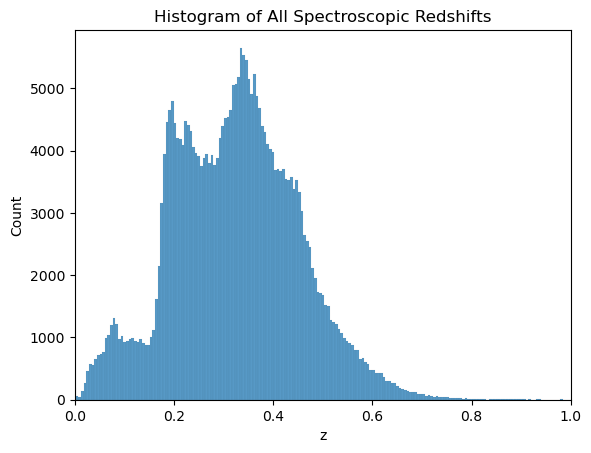

In [19]:
sns.histplot(data.z)
plt.xlim(0,1)
plt.title("Histogram of All Spectroscopic Redshifts")
plt.show()

In [20]:
bins = np.arange(0,1.005, 0.005)
len(bins)

201

In [21]:
def undersample(bins, df, limit):
    undersample_ind = []
    for ind, binval in enumerate(bins[1:]):
        sources = df.query("z>@bins[@ind] & z<@binval").index.values.tolist()
        if len(sources) > limit:
            rand_selection = np.random.choice(sources, size=limit, replace=False)
        else:
            rand_selection = sources
        undersample_ind.extend(rand_selection)
    return undersample_ind

In [22]:
undersample_ind = undersample(bins=bins, df=data, limit=1000 )


In [23]:
old_data = data
data = data[data.index.isin(undersample_ind)].reset_index(drop=True)

In [24]:
old_data.to_csv("Teddy_custom.csv", index=False)
data.to_csv("Teddy_custom_undersamp.csv", index=False)

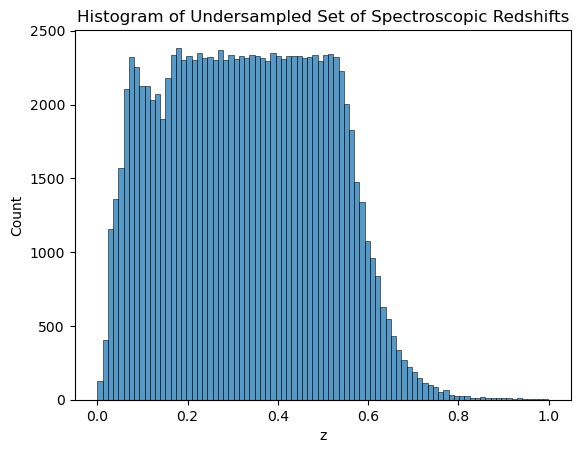

In [25]:
sns.histplot(data.z)
# plt.xlim(0,1)
plt.title("Histogram of Undersampled Set of Spectroscopic Redshifts")
plt.show()

In [30]:
len(data)

113324

# The Dataset is now ready for Machine Learning

In [34]:
test_size = 0.4 #60/40 train/test split
random_state = 42

In [35]:
x = data.drop("z", axis=1)
y = data[["z"]]

In [36]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=random_state)

In [ ]:
# SDSS_data = x_train[["rMagNormSDSS","ugNormSDSS","grNormSDSS","riNormSDSS","izNormSDSS"]]
# SDSS_colors =  x_train[["ugNormSDSS","grNormSDSS","riNormSDSS","izNormSDSS"]]
# PanSTARRS_data = x_train[["rMagNormPS","grNormPS","riNormPS","izNormPS","zyNormPS"]]
# SD_PS_data = x_train[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS"]]
# all_data = x_train[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS", "yjNorm", "jhNorm", "hkNorm"]]
# alt_data = x_train[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS", "jDetected","hDetected","kDetected"]]

# SDSS_data_test = x_test[["rMagNormSDSS","ugNormSDSS","grNormSDSS","riNormSDSS","izNormSDSS"]]
# SDSS_colors_test =  x_test[["ugNormSDSS","grNormSDSS","riNormSDSS","izNormSDSS"]]
# PanSTARRS_data_test = x_test[["rMagNormPS","grNormPS","riNormPS","izNormPS","zyNormPS"]]
# SD_PS_data_test = x_test[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS"]]
# all_data_test = x_test[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS", "yjNorm", "jhNorm", "hkNorm"]]
# alt_data_test = x_test[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS", "jDetected","hDetected","kDetected"]]


### Model Training SDSS U + PS1 Info

In [ ]:
sdps_xtrain = x_train[['rMagNormPS', 'ugNorm', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS']]
sdps_xtest = x_test[['rMagNormPS', 'ugNorm', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS']]

In [39]:
model = flexcode.FlexCodeModel(CustomModel, max_basis=31, basis_system="cosine", custom_model=XGBRegressor)

In [ ]:
model.fit(sdps_xtrain, y_train.values)

In [ ]:
n_grid = 1000

cdes, z_grid = model.predict(sdps_xtest, n_grid=n_grid)


In [ ]:
cde_loss_val, std_cde_loss = cde_loss(cdes, z_grid, y_test.values)


In [ ]:
print('CDE Loss PS     : %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))


In [ ]:
plot_cde_range(cdes, y_test, z_grid, [0,0.06], [4,3])
print("Next Plot")
plot_cde_range(cdes, y_test, z_grid, [0,1], [4,3], subset=[11,24])

In [ ]:
z_grid = np.linspace(y_train.min(), y_train.max(), n_grid)
pit_values = cdf_coverage(cdes, z_grid, y_test.values)
hpd_values = hpd_coverage(cdes, z_grid, y_test.values)

In [ ]:
sns.histplot(pit_values)
plt.title("PIT Values")
plt.show()

In [ ]:
sns.histplot(hpd_values)
plt.title("HPD Values")
plt.show()

### Model Training 2MASS Low Error

Using same features as above, only adding detections with 2Mass errors below 0.05

In [ ]:
data["yj_err"] = np.sqrt((data.yKronMagErr)**2 + (data.j_err)**2)
data["jh_err"] = np.sqrt((data.j_err)**2 + (data.h_err)**2)
data["hk_err"] = np.sqrt((data.h_err)**2 + (data.k_err)**2)


In [ ]:
err_data = data.dropna()

In [ ]:
frames = [err_data.yj_err, err_data.jh_err, err_data.hk_err]
err_df = pd.concat(frames, keys=["yj_err", "jh_err", "hk_err"]).to_frame().reset_index().rename(columns={0:"err_val","level_0":"err_type"}).drop("level_1", axis=1)
sns.histplot(data=err_df, x=err_df.err_val, hue="err_type", multiple="stack")
plt.title("Stacked Histogram of 2MASS Colour Errors")
plt.show()

In [ ]:
thresh = 0.07
low_err_data = err_data.query("yj_err <= @thresh &\
                               jh_err <= @thresh &\
                               hk_err <= @thresh")
low_err_data.columns

In [ ]:
x = low_err_data.drop("z", axis=1)
y = low_err_data["z"]

In [ ]:
sns.histplot(y)
plt.xlim(0,0.2)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=random_state)

In [ ]:
x_train_no_err = x_train[['rMagNormPS', 'ugNorm', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS']]
x_test_no_err = x_test[['rMagNormPS', 'ugNorm', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS']]

x_train_err = x_train[['rMagNormPS', 'ugNorm', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS','yjNorm','jhNorm','hkNorm']]
x_test_err = x_test[['rMagNormPS', 'ugNorm', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS','yjNorm','jhNorm','hkNorm']]


In [ ]:
model_no_err = flexcode.FlexCodeModel(CustomModel, max_basis=31, basis_system="cosine", custom_model=XGBRegressor)
model_err = flexcode.FlexCodeModel(CustomModel, max_basis=31, basis_system="cosine", custom_model=XGBRegressor, regression_params={"importance_type":"gain"})

In [ ]:
model_no_err.fit(x_train_no_err, y_train.values)
model_err.fit(x_train_err, y_train.values)

In [ ]:
n_grid = 1000
cdes_no_err, z_grid_no_err = model_no_err.predict(x_test_no_err, n_grid=n_grid)
cdes_err, z_grid_err = model_err.predict(x_test_err, n_grid=n_grid)

In [ ]:
cde_noerr_loss, std_cde_noerr_loss = cde_loss(cdes_no_err, z_grid_no_err, y_test.values)
cde_err_loss, std_cde_err_loss = cde_loss(cdes_err, z_grid_err, y_test.values)


In [ ]:
print('CDE Loss No 2MASS Model     : %4.2f \pm %.2f' % (cde_noerr_loss, std_cde_noerr_loss))
print('CDE Loss 2MASS Model     : %4.2f \pm %.2f' % (cde_err_loss, std_cde_err_loss))

### Sample CDES for Model No 2MASS Features

In [ ]:
plot_cde_range(cdes_no_err, y_test, z_grid_no_err, [0,0.06], [4,3])
print("Next Plot")
plot_cde_range(cdes_no_err, y_test, z_grid_no_err, [0.06,10], [4,3], subset=[11,24])

### Sample CDES for Model with 2MASS Features

In [ ]:
plot_cde_range(cdes_err, y_test, z_grid_err, [0,0.06], [4,3])
print("Next Plot")
plot_cde_range(cdes_err, y_test, z_grid_err, [0.06,10], [4,3], subset=[11,24])

In [ ]:
from xgboost import plot_importance, plot_tree

plot_tree(model_err.model.models.estimators_[8])
fig = plt.gcf()
fig.set_size_inches(75, 50)

plt.figure()
plot_importance(model_err.model.models.estimators_[8])

In [ ]:
z_grid = np.linspace(y_train.min(), y_train.max(), n_grid)
pit_values = cdf_coverage(cdes_no_err, z_grid, y_test.values)
hpd_values = hpd_coverage(cdes_no_err, z_grid, y_test.values)
sns.histplot(pit_values)
plt.title("PIT Values No 2MASS")
plt.show()
sns.histplot(hpd_values)
plt.title("HPD Values No 2MASS")
plt.show()

In [ ]:
z_grid = np.linspace(y_train.min(), y_train.max(), n_grid)
pit_values = cdf_coverage(cdes_err, z_grid, y_test.values)
hpd_values = hpd_coverage(cdes_err, z_grid, y_test.values)
sns.histplot(pit_values)
plt.title("PIT Values 2MASS")
plt.show()
sns.histplot(hpd_values)
plt.title("HPD Values 2MASS")
plt.show()